## Init & utils

In [ ]:
%%bash
# tar -cvzf pr_4.tgz pr | wc -l
# tar -cvzf pr_tables.tgz pr_tables*.json
# tar -xvzf pr_tables.tgz
# tar -xvzf pr_4.tgz | wc -l
ls pr | wc -l

In [ ]:
import collections
import os

from jsonpath_rw import jsonpath, parse
import jsonpath_rw_ext as jsonp

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

In [ ]:
import json 
from json import JSONEncoder, JSONDecoder
import pickle

class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (list, dict, str, unicode, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct

def save_to_json_file(filename, content):
    temp = json.dumps(content, cls=PythonObjectEncoder)
    return save_to_file(filename, temp)

def save_to_file(filename, content):
    with open(filename, 'w') as file:
        file.write(content)
    return "saved " + filename    

def load_from_json_file(file_name):
    content = load_from_file(file_name)
    return json.load(content, object_hook=as_python_object)

def load_from_file(file_name):
    return open(file_name)

In [ ]:
import copy

def inc_dict_val(d, k, v):
    d[k] = int(d.get(k, 0)) + int(v)

def alter_dict(D, **F):
    result = copy.deepcopy(D)    
    result.update(**F)
    return result   

def map_dict(src, *args, **kvargs):
    dst = dict()
    for v in args:
        dst[v] = src[v]
    for k,v in kvargs.items():
        dst[k] = src[v]
    return dst

def remove_from_dict(d, key):
    if key in d:
        del d[key]

## Printing

In [ ]:
from pprint import pprint
from IPython.display import JSON

width = 180
def print_line(char=' '):
    print(char*width)

In [ ]:
import re

def print_log(log, consumer=print, **args):
    if log:
        params = {g:'' for g in re.findall('\$\{([^}]+)\}', log)}
        params.update(args)
        consumer(log.replace('$', '').format(**params))

In [ ]:
from jsondiff import diff

def print_diff(old_dict, new_dict, consumer=print):     
    consumer(get_diff(old_dict, new_dict))
    
def get_diff(old_dict, new_dict):     
    return diff(old_dict, new_dict, syntax='symmetric')

In [ ]:
points = [1, 5, 20, 100, 500, 1000]

import sys
import time

def print_progress(i, timer_log=None, total=None):
    if (i % points[0] == 0):
        if i > 0 and (i % points[1] == 0):
            sys.stdout.write(' ')
            if (i % points[2] == 0):
                sys.stdout.write('  ')
                if (i % points[3] == 0):
                    sys.stdout.write('\n')
                    if (i % points[4] == 0):
                        sys.stdout.write('\n')
                        if total and (i % points[5] == 0):                            
                            timer_log = print_stats(total, i, points[5], timer_log)
        sys.stdout.write('.')
        sys.stdout.flush()   
        
def print_stats(total, processed, bunch, last_time, **kwargs):
    now = time.time()
    speed = (now-last_time)/60.0/bunch
    eta = speed*(total-processed)
    print('speed: {speed:.1f} min/bunch, eta: {eta:.2f} min\n'.format(speed = speed, eta = eta, **kwargs))
    return now

def with_progress(l, size=None):
    for i,v in enumerate(l):
        print_progress(i, time.time(), size)
        yield v

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding-right: 100px;"'),raw=True)

## Analitical fn

In [ ]:
def collect_data(files, collector):
    for f in files:
        data = load_from_json_file(f)
        yield collector(data)

def flattern(data):
    return [l2 for l1 in data for l2 in l1]

def get_nodes(data, ptr):
    return [match.value for match in jsonp.parse(ptr).find(data)]

In [ ]:
def select_all(key):
    return lambda data: jsonp.match(key, data)

def select_one(key):
    return lambda data: jsonp.match1(key, data)

def contains(key, value):
    return lambda data: jsonp.match1(key, data) == value

def all_of(*filters):
    def fn(data):
        for f in filters:
            if not f(data):
                return False
        return True  
    return fn

In [ ]:
def for_each(data, *funs):
    for fun in funs:
        data = fun(data)
    return data

## Analysis

In [ ]:
from os import listdir
from os.path import isfile, join

game = 'pr'
games = [join(game, f) for f in listdir(game) if f.endswith('.json')]
len(games)

In [ ]:
games.sort()
datas = [load_from_json_file(f) for f in with_progress(games[(len(games) % 100):])]


# ACTIVE DEVELOPMENT ZONE


In [ ]:
def steps(log):
    for move_id, move in enumerate(log):
        for sub_move_id, sub_move in enumerate(move['data']):
            yield sub_move

In [ ]:
stats = for_each(datas,
                 select_all('$[*].log.data.data.data'),
                 select_all('$[*][*].data[?(@.type == "gameStateChange" & @.args.action == "stGameEnd")].args.args')
                )

In [ ]:
for i,t in enumerate(datas):
    stats[i]['table_id'] = t['table'] 

In [ ]:
stats = sorted(stats, key=lambda g: int(g['table']['stats']['2']), reverse=True)

In [43]:
df_table = json_normalize(data=stats)
df_table.head(3)

,result,table.concede,table.disagreement,table.neutralized,table.stats.1,table.stats.10,table.stats.11,table.stats.12,table.stats.13,table.stats.14,table.stats.15,table.stats.16,table.stats.2,table.stats.3,table.stats.4,table_id
0,"[{'name': 'kostra', 'color': 'ffa500', 'score'...",False,False,0,4,0,7,75,16,0,14,0,58.0,66,NaN,44160632
1,"[{'name': 'Krunch', 'color': '008000', 'score'...",False,False,0,4,0,11,68,24,1,14,0,56.5,72,NaN,44124319
2,"[{'name': 'solan 1', 'color': '008000', 'score...",False,False,0,4,0,0,62,14,2,13,0,56.0,59,NaN,44263507


In [46]:
df_player = json_normalize(data=stats, record_path=['result'], meta='table_id', )
df_player.head(3)

,color,color_back,concede,name,player,rank,score,score_aux,stats,tie,zombie,table_id
0,ffa500,None,0,kostra,5770116,1,66,7,"{'1': '11.5333', '10': '29', '11': '24', '12':...",False,0,44160632
1,0000ff,None,0,kanchoh,57797129,2,60,0,"{'1': '15.7', '10': '33', '11': '20', '12': 7,...",False,0,44160632
2,008000,None,0,captgroggy,84692900,3,59,4,"{'1': '24.2833', '10': '34', '11': '20', '12':...",False,0,44160632


In [ ]:
df_player1 = json_normalize(data=stats, record_path=['result'], meta='table_id', )
df_player1.head(30)

In [34]:
stats[3]['result'][1]['stats']

{'1': '14.65',
 '10': '21',
 '11': '23',
 '12': 14,
 '13': '0',
 '14': '1',
 '15': '18',
 '16': '9',
 '17': '1',
 '18': '7',
 '19': '2'}

In [ ]:
game_log = datas[1]['log']['data']['data']['data']
res = game_log[-1]['data'][-2]['args']['args']
pprint(res, width=width)

In [ ]:
d = [[
    int(p['rank']),
    int(p['stats']['10']),
    int(p['stats']['11']),     
    int(p['stats']['12'])    
] for game in stats for p in game['result']]
d = list(zip(*d))

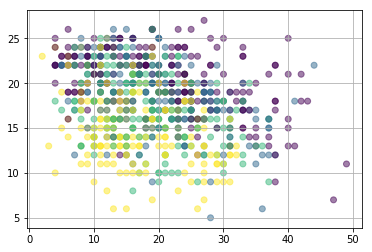

In [33]:
fig, ax = plt.subplots()
ax.scatter(d[1], d[2], c=d[0], alpha=0.5)
ax.grid(True)
plt.show()

<module 'matplotlib.pyplot' from '/srv/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

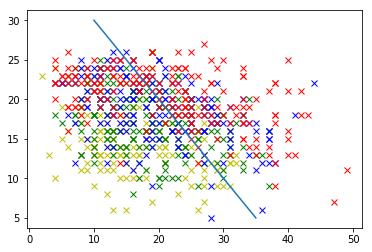

<Figure size 720x720 with 0 Axes>

In [23]:
br = 40
plt.plot(
    [int(p['result'][3]['stats']['10']) for p in stats], [int(p['result'][3]['stats']['11']) for p in stats], 'yx',
    [int(p['result'][2]['stats']['10']) for p in stats], [int(p['result'][2]['stats']['11']) for p in stats], 'gx',
    [int(p['result'][1]['stats']['10']) for p in stats], [int(p['result'][1]['stats']['11']) for p in stats], 'bx',
    [int(p['result'][0]['stats']['10']) for p in stats], [int(p['result'][0]['stats']['11']) for p in stats], 'rx',
    [br-5, br-30], [5, 30]
)
# plt.axis([0, 52,0, 30])
plt.figure(figsize=(10,10))
plt.show()

<BarContainer object of 33 artists>

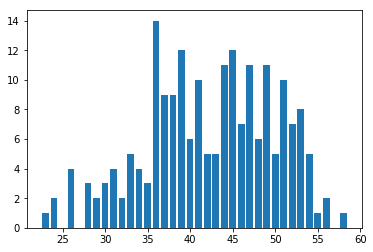

In [97]:
avg = [int(p['table']['stats']['2']) for p in stats]
count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])

In [69]:
table_stats = {
     '1': '_',
     '4': 'Game duration',
     '3': 'Players average level',
     '2': 'Average score',
    '10': 'Unclaimed victory points',
    '11': 'Unclaimed colonists',
    '12': 'Doubloons in the bank',
    '13': 'Unclaimed plantations',
    '14': 'Unclaimed quarries',
    '15': 'Unclaimed small buildings',
    '16': 'Unclaimed large buildings'}

player_stats = {
     '1': 'Thinking time',
    '10': 'VPs earned by shipping',
    '11': 'VPs earned by building',
    '12': 'VPs earned from large buildings',
    '13': 'Doubloons owned at game end',
    '14': 'Good barrels owned at game end',
    '15': 'Colonists',
    '16': 'Plantations',
    '17': 'Quarries',
    '18': 'Small buildings',
    '19': 'Large buildings'}

tdf = pd.DataFrame([table_stats, res['table']['stats']]).T
pdf = pd.DataFrame(
    data  = [player_stats] + [x['stats']  for x in res['result']], 
    index =       ['name'] + [x['player'] for x in res['result']]
).T

display_side_by_side(pdf, tdf)

,name,83864705,83914097,1019711,84006291
1,Thinking time,20216.4,22930,13674.8,29593.3
10,VPs earned by shipping,33,37,18,19
11,VPs earned by building,20,16,19,17
12,VPs earned from large buildings,8,6,12,7
13,Doubloons owned at game end,2,3,4,3
14,Good barrels owned at game end,5,1,1,0
15,Colonists,15,15,16,15
16,Plantations,9,9,7,11
17,Quarries,1,1,3,1
18,Small buildings,7,6,6,6


In [ ]:
group = ['scoreShippingPoints', 'scoreConditionalPoints', 'scoreEndPoints', 'buildingBought']
selected = [s for s in steps(game_log) if s['type'] in group]
argsByType = lambda t: [s['args'] for s in selected if s['type'] == t]

buildings = {s['bld_id']: {
    'player_id': s['player_id'], 
    'building': s['bld_type_tr'],
    'score': int(s['score_delta'])
} for s in argsByType('buildingBought')}

buildings_score = {}
for b in buildings.values():
    buildings_score.setdefault(b['player_id'], 0)
    buildings_score[b['player_id']] += b['score']

JSON({
    'shipping'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreShippingPoints')},
    'conditional': {s['building_name']: {
        s['player_id']: int(s['score_delta'])
    } for s in argsByType('scoreConditionalPoints')},
    'endScore'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreEndPoints')},
    'buildings_s': buildings_score,
    'buildings'  : buildings
}, width=width)

In [ ]:
flat = [s for s in steps(game_log) if s['type'] not in ['gameStateChange', 'message', 'updateReflexionTime']]
c = collections.Counter([s['type'] for s in flat])
c.most_common(20)

In [ ]:
# pprint(stats[7], width=width)